# Pyro Cookie Factory: Pooled, Unpooled, and Hierarchical Models

This notebook demonstrates hierarchical Bayesian inference in Pyro using the
cookie-chip factory example by [Juan Orduz](https://juanitorduz.github.io/cookies_example_numpyro/). 


We compare three models:

- Pooled: one shared rate for all locations
- Unpooled: independent rates per location
- Hierarchical: location rates drawn from a shared distribution (partial pooling)

Learning goals:
- Understand plate notation and batched likelihoods in Pyro
- See how partial pooling reduces overfitting and uncertainty for small-n groups
- Interpret posterior summaries and visualize shrinkage

In [ ]:
# NOTE: Set to True if running in Google Colab.
colab = False

if colab:
    !git clone https://github.com/janfb/pyro-meets-sbi.git
    %cd pyro-meets-sbi

    !uv pip install .

In [ ]:
# Imports and setup (Pyro only)
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS

from utils import load_cookie_dataset

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Seeds for reproducibility
torch.manual_seed(42)
pyro.set_rng_seed(42)
pyro.clear_param_store()

print(f"Pyro {pyro.__version__} | PyTorch {torch.__version__}")

Pyro 1.9.1 | PyTorch 2.5.1


## Data: Cookie Chip Counts

Our dataset contains chocolate chip counts from cookies produced at 5 different factory locations. Each location follows the same global recipe but shows location-specific variation.

**The challenge**: How do we model both global patterns and local variations in a principled way?

In [2]:
cds = load_cookie_dataset()  # CookieDataset dataclass

cookies = cds.cookies
location_stats = cds.location_stats
locations = cds.locations
chips = cds.chips
n_locations = cds.n_locations
location_rates = cds.location_rates
sample_sizes = cds.sample_sizes
true_rates = cds.true_rates

print(f"Loaded dataset: {len(cookies)} cookies from {n_locations} locations")
print(f"CSV path: {cds.path}")
print(location_stats)

Loaded dataset: 125 cookies from 5 locations
CSV path: /Users/janteusen/qode/pyro-meets-sbi/data/cookie_chips_data.csv
  location       mean       std  count
0        1   9.033333  3.614943     30
1        2   5.733333  2.715642     30
2        3  10.000000  2.982709     30
3        4   8.300000  2.781094     30
4        5   9.600000  4.560702      5


## Data Visualization

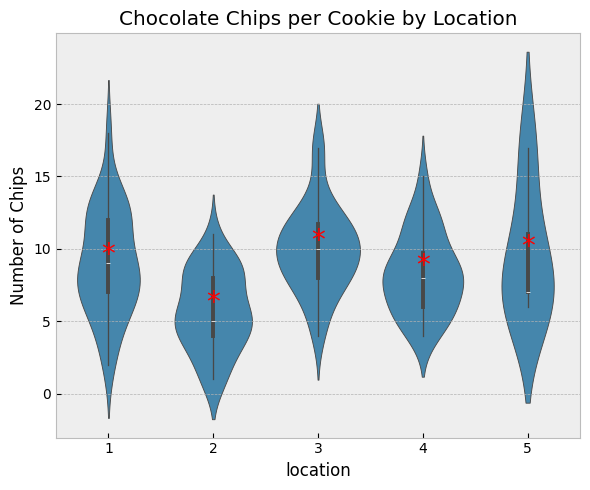

In [3]:
# Visualize the data structure
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

# Location-specific distributions
sns.violinplot(data=cookies, x="location", y="chips", ax=ax1)
ax1.set_title("Chocolate Chips per Cookie by Location")
ax1.set_ylabel("Number of Chips")

# Add true location rates as stars for each location
for i, rate in enumerate(location_rates):
    ax1.text(i, rate, "*", color="red", fontsize=20, ha="center")

plt.tight_layout()
plt.show()

# Key observation: Clear differences suggest hierarchical modeling

## Part 1: Pooled Model in Pyro

**Assumption**: All locations share the same rate parameter

```
chips ~ Poisson(λ)
λ ~ Gamma(2, 0.2)
```

This simple model ignores location differences - let's see how it performs.

In [4]:
# Pooled model: one shared rate for all locations


def model_pooled(locations, chips=None):
    lam = pyro.sample("lam", dist.Gamma(concentration=2.0, rate=1 / 5))
    with pyro.plate("data", size=len(locations)):
        pyro.sample("obs", dist.Poisson(lam), obs=chips)


pyro.clear_param_store()
nuts_pooled = NUTS(model_pooled, target_accept_prob=0.9)
mcmc_pooled = MCMC(nuts_pooled, num_samples=2000, warmup_steps=1000, num_chains=1)
mcmc_pooled.run(locations, chips)
posterior_pooled = mcmc_pooled.get_samples()
lam_pooled = posterior_pooled["lam"]
print(f"Pooled λ mean: {lam_pooled.mean().item():.3f}")

Sample: 100%|██████████| 3000/3000 [00:03, 866.13it/s, step size=8.50e-01, acc. prob=0.953]

Pooled λ mean: 8.321


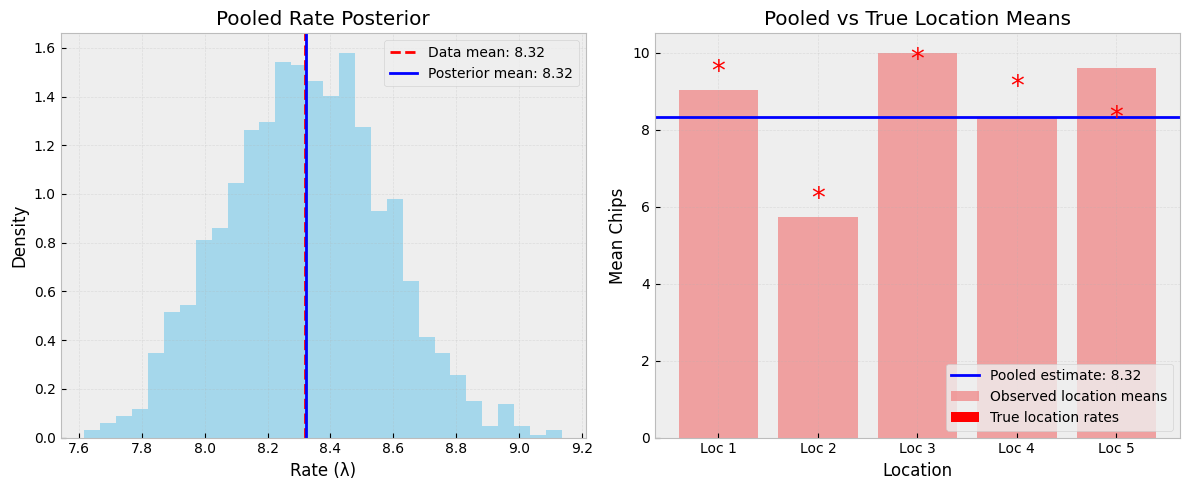

❌ Problem: Pooled model misses location-specific differences!


In [5]:
# Visualize pooled model results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Posterior distribution
ax1.hist(lam_pooled.numpy(), bins=30, alpha=0.7, density=True, color="skyblue")
ax1.axvline(
    chips.mean(), color="red", linestyle="--", label=f"Data mean: {chips.mean():.2f}"
)
ax1.axvline(
    lam_pooled.mean().item(),
    color="blue",
    linestyle="-",
    label=f"Posterior mean: {lam_pooled.mean().item():.2f}",
)
ax1.set_xlabel("Rate (λ)")
ax1.set_ylabel("Density")
ax1.set_title("Pooled Rate Posterior")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Compare with location-specific means
x_pos = range(n_locations)
ax2.bar(
    x_pos,
    location_stats["mean"],
    alpha=0.7,
    color="lightcoral",
    label="Observed location means",
)
ax2.axhline(
    lam_pooled.mean().item(),
    color="blue",
    linestyle="-",
    linewidth=2,
    label=f"Pooled estimate: {lam_pooled.mean().item():.2f}",
)

ax2.set_xlabel("Location")
ax2.set_ylabel("Mean Chips")
ax2.set_title("Pooled vs True Location Means")
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"Loc {i + 1}" for i in range(n_locations)])
ax2.grid(True, alpha=0.3)
# add star marker for each true underlying chip rate for each location
for i, rate in enumerate(true_rates):
    ax2.text(i, rate, "*", color="red", fontsize=20, ha="center")
# add entry to legend
# add single legend handle for true rates
true_rates_handle = ax2.bar(0, 0, color="red", label="True location rates")
# ax2.legend(['Pooled estimate', "observed location means", true_rates_handle])
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

print("❌ Problem: Pooled model misses location-specific differences!")

## Part 2: Unpooled Model in Pyro

**Assumption**: Each location is completely independent with its own rate parameter

```
chips[ℓ] ~ Poisson(λ[ℓ])
λ[ℓ] ~ Gamma(2, 0.2)  # Independent priors
```

This allows for location-specific effects but doesn't share information across locations. **Notice location 5 has only 10 observations** - let's see how this affects uncertainty.

### Takeaways from the pooled model
- One global rate (λ) fits the overall mean reasonably well, but it ignores clear differences between locations.
- The pooled estimate can over/underestimate specific locations, and uncertainty is unrealistically narrow for small-n groups.
- To capture location-specific effects, we need separate rates per location. Next: the unpooled model.

In [6]:
def model_unpooled(locations, chips=None):
    # Unpooled model: independent rate per location
    with pyro.plate("location", n_locations):
        lam = pyro.sample("lam", dist.Gamma(concentration=2.0, rate=1 / 5))
    rate = lam[locations]
    with pyro.plate("data", size=len(locations)):
        pyro.sample("obs", dist.Poisson(rate), obs=chips)


pyro.clear_param_store()
nuts_unpooled = NUTS(model_unpooled, target_accept_prob=0.9)
mcmc_unpooled = MCMC(nuts_unpooled, num_samples=2000, warmup_steps=1000, num_chains=1)
mcmc_unpooled.run(locations, chips)
posterior_unpooled = mcmc_unpooled.get_samples()
lam_unpooled = posterior_unpooled["lam"]
print("Unpooled λ means per location:", lam_unpooled.mean(0).numpy().round(3))

Sample: 100%|██████████| 3000/3000 [00:07, 403.96it/s, step size=6.21e-01, acc. prob=0.934]

Unpooled λ means per location: [9.027 5.777 9.987 8.301 9.607]


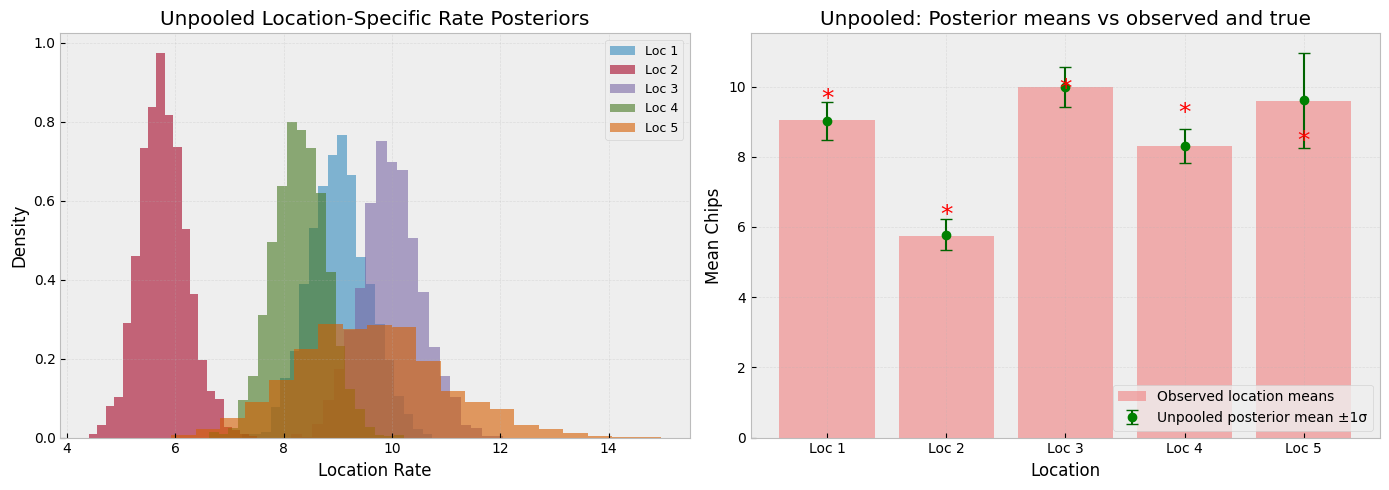

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Location rate uncertainties (histograms)
ax = axes[0]
for i in range(n_locations):
    ax.hist(
        posterior_unpooled["lam"][:, i].numpy(),
        bins=20,
        alpha=0.6,
        density=True,
        label=f"Loc {i + 1}",
    )
ax.set_xlabel("Location Rate")
ax.set_ylabel("Density")
ax.set_title("Unpooled Location-Specific Rate Posteriors")
ax.legend(fontsize=9, loc="best")
ax.grid(True, alpha=0.3)

# Right: Per-location estimates vs observed means and true rates
ax2 = axes[1]
x_pos = np.arange(n_locations)
# Observed means as bars
ax2.bar(
    x_pos,
    location_stats["mean"],
    alpha=0.6,
    color="lightcoral",
    label="Observed location means",
)
# Unpooled posterior mean ±1σ as error bars
unpooled_means = lam_unpooled.mean(0)
unpooled_stds = lam_unpooled.std(0)
ax2.errorbar(
    x_pos,
    unpooled_means.numpy(),
    yerr=unpooled_stds.numpy(),
    fmt="o",
    color="green",
    ecolor="darkgreen",
    elinewidth=1.5,
    capsize=4,
    label="Unpooled posterior mean ±1σ",
)
# True underlying rates as stars
for i, rate in enumerate(true_rates):
    ax2.text(i, rate, "*", color="red", fontsize=18, ha="center", va="bottom")

ax2.set_xticks(x_pos)
ax2.set_xticklabels([f"Loc {i + 1}" for i in range(n_locations)])
ax2.set_xlabel("Location")
ax2.set_ylabel("Mean Chips")
ax2.set_title("Unpooled: Posterior means vs observed and true")
ax2.grid(True, alpha=0.3)
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Part 3: Hierarchical Model in Pyro

### Takeaways from the unpooled model
- Independent rates per location recover local means and uncertainties, but they do not share information across groups.
- Small-sample locations (e.g., fewer cookies) exhibit high uncertainty and can overfit noise.
- We want a model that allows differences but borrows strength across locations: the hierarchical model.


**Key insight**: Locations are different but related. Each location has its own rate, but rates are drawn from a shared distribution.

```
chips[ℓ] ~ Poisson(λ[ℓ])
λ[ℓ] ~ Gamma(α, β)
α = μ²/σ²
β = μ/σ²
μ ~ Gamma(2, 0.2)
σ ~ Exponential(1)
```

This enables **partial pooling**: extreme estimates get pulled toward the global mean while preserving meaningful differences. **Watch how location 5 gets tighter posteriors despite fewer observations!**

In [8]:
def hierarchical_model(locations, chips=None):
    """Hierarchical model: each location has its own rate from shared distribution"""
    # Hyperpriors
    mu = pyro.sample("mu", dist.Gamma(concentration=2.0, rate=1 / 5))
    sigma = pyro.sample("sigma", dist.Exponential(rate=1.0))

    # Derived parameters
    alpha = mu**2 / sigma**2
    beta = mu / sigma**2

    # Location-specific rates
    with pyro.plate("location", n_locations):
        lam = pyro.sample("lam", dist.Gamma(concentration=alpha, rate=beta))

    # Likelihood per observation
    rate = lam[locations]
    with pyro.plate("data", size=len(locations)):
        pyro.sample("obs", dist.Poisson(rate=rate), obs=chips)

    return lam


# Run MCMC inference
pyro.clear_param_store()
nuts_kernel = NUTS(hierarchical_model, target_accept_prob=0.9)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)
mcmc.run(locations, chips)  # float chips for Pyro

hierarchical_posterior = mcmc.get_samples()
hierarchical_rates = hierarchical_posterior["lam"].mean(dim=0)
lam_hier = hierarchical_posterior["lam"]

print(
    f"Hierarchical model fitted. Global μ = {hierarchical_posterior['mu'].mean():.3f} ± {hierarchical_posterior['mu'].std():.3f}"
)
print(
    f"Hierarchical: Location 5 (n={sample_sizes[4]}): λ = {hierarchical_rates[4]:.3f} (true: {true_rates[4]:.2f})"
)

Sample: 100%|██████████| 3000/3000 [00:17, 167.19it/s, step size=4.04e-01, acc. prob=0.945]

Hierarchical model fitted. Global μ = 8.443 ± 0.809
Hierarchical: Location 5 (n=5): λ = 9.144 (true: 8.10)


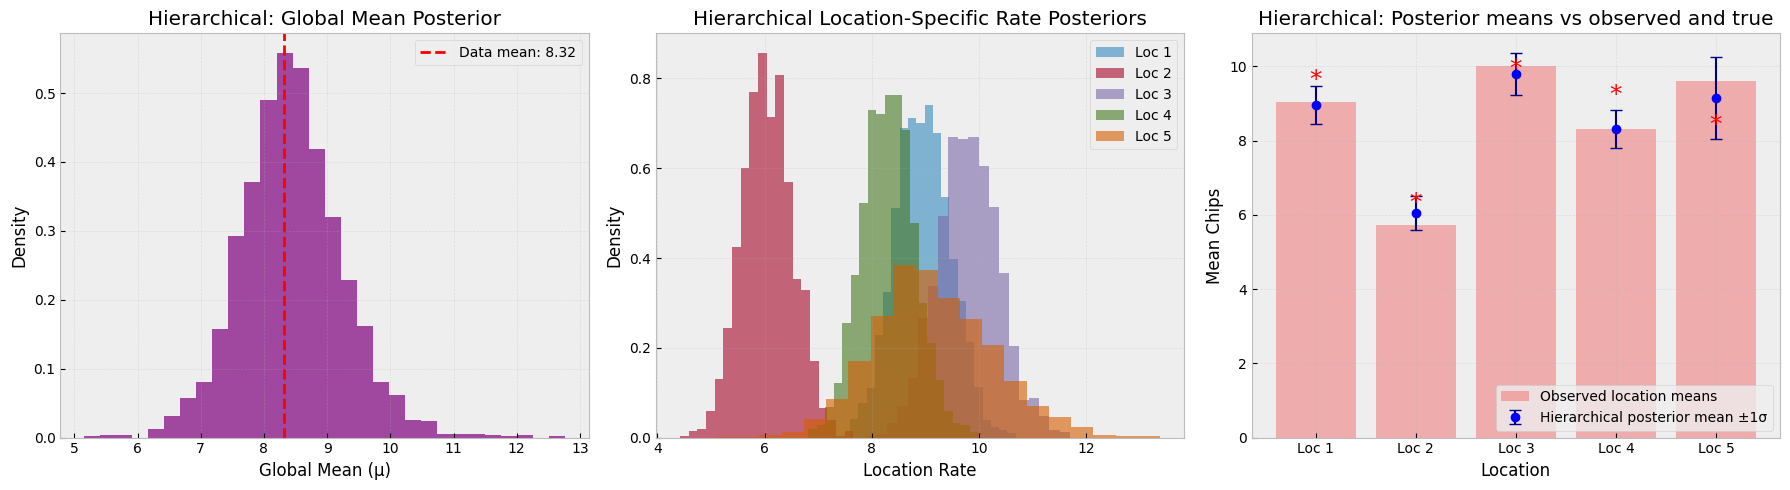

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: Global parameter posterior (mu)
axes[0].hist(
    hierarchical_posterior["mu"].numpy(),
    bins=30,
    alpha=0.7,
    color="purple",
    density=True,
)
axes[0].axvline(
    chips.mean(), color="red", linestyle="--", label=f"Data mean: {chips.mean():.2f}"
)
axes[0].set_xlabel("Global Mean (μ)")
axes[0].set_ylabel("Density")
axes[0].set_title("Hierarchical: Global Mean Posterior")
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(True, alpha=0.3)

# Middle: Location rate uncertainties (histograms)
for i in range(n_locations):
    axes[1].hist(
        hierarchical_posterior["lam"][:, i].numpy(),
        bins=20,
        alpha=0.6,
        density=True,
        label=f"Loc {i + 1}",
    )
axes[1].set_xlabel("Location Rate")
axes[1].set_ylabel("Density")
axes[1].set_title("Hierarchical Location-Specific Rate Posteriors")
axes[1].legend(fontsize=10, loc="best")
axes[1].grid(True, alpha=0.3)

# Right: Per-location estimates vs observed means and true rates
x_pos = np.arange(n_locations)
# Compute hierarchical posterior means/stds per location
hier_means = hierarchical_posterior["lam"].mean(0)
hier_stds = hierarchical_posterior["lam"].std(0)

# Observed means as bars
axes[2].bar(
    x_pos,
    location_stats["mean"],
    alpha=0.6,
    color="lightcoral",
    label="Observed location means",
)
# Hierarchical posterior mean ±1σ as error bars
axes[2].errorbar(
    x_pos,
    hier_means.numpy(),
    yerr=hier_stds.numpy(),
    fmt="o",
    color="blue",
    ecolor="navy",
    elinewidth=1.5,
    capsize=4,
    label="Hierarchical posterior mean ±1σ",
)
# True underlying rates as stars
for i, rate in enumerate(true_rates):
    axes[2].text(i, rate, "*", color="red", fontsize=18, ha="center", va="bottom")

axes[2].set_xticks(x_pos)
axes[2].set_xticklabels([f"Loc {i + 1}" for i in range(n_locations)])
axes[2].set_xlabel("Location")
axes[2].set_ylabel("Mean Chips")
axes[2].set_title("Hierarchical: Posterior means vs observed and true")
axes[2].grid(True, alpha=0.3)
axes[2].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [10]:
# Save all three posteriors to file
import pickle

with open("../../data/cookie_posteriors.pkl", "wb") as f:
    pickle.dump(
        {
            "pooled": posterior_pooled,
            "unpooled": posterior_unpooled,
            "hierarchical": hierarchical_posterior,
        },
        f,
    )
print("✅ Saved all posteriors to cookie_posteriors.pkl")

✅ Saved all posteriors to cookie_posteriors.pkl


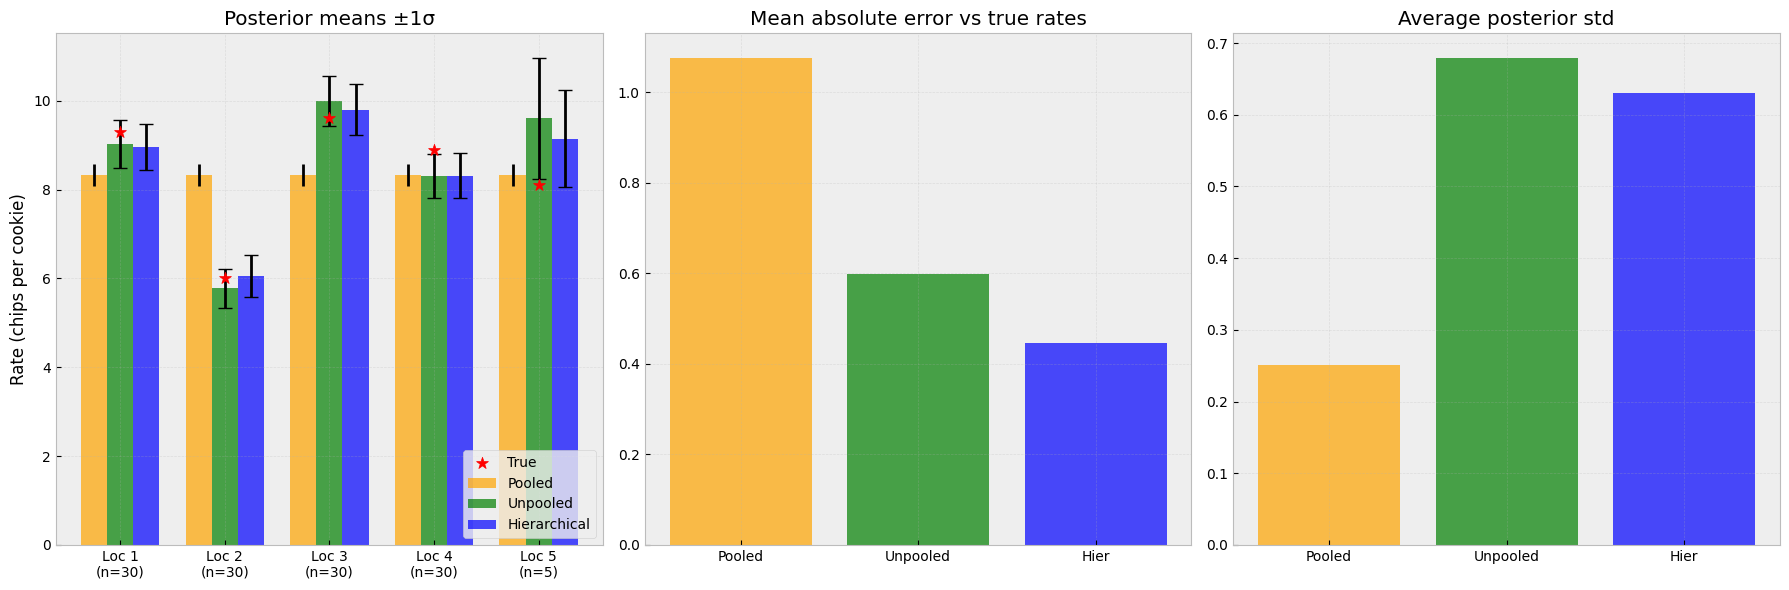

In [11]:
pooled_mean = lam_pooled.mean()
pooled_std = lam_pooled.std()
pooled_means = torch.full((n_locations,), pooled_mean)
pooled_stds = torch.full((n_locations,), pooled_std)

unpooled_means = lam_unpooled.mean(0)
unpooled_stds = lam_unpooled.std(0)

hier_means = lam_hier.mean(0)
hier_stds = lam_hier.std(0)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
x_pos = np.arange(n_locations)
width = 0.25

axes[0].bar(
    x_pos - width,
    pooled_means,
    width,
    yerr=pooled_stds,
    alpha=0.7,
    color="orange",
    label="Pooled",
)
axes[0].bar(
    x_pos,
    unpooled_means,
    width,
    yerr=unpooled_stds,
    alpha=0.7,
    color="green",
    label="Unpooled",
    capsize=5,
)
axes[0].bar(
    x_pos + width,
    hier_means,
    width,
    yerr=hier_stds,
    alpha=0.7,
    color="blue",
    label="Hierarchical",
    capsize=5,
)
axes[0].scatter(
    x_pos, true_rates, color="red", s=80, label="True", marker="*", zorder=5
)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(
    [f"Loc {i + 1}\n(n={sample_sizes[i]})" for i in range(n_locations)]
)
axes[0].set_ylabel("Rate (chips per cookie)")
axes[0].set_title("Posterior means ±1σ")
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

pooled_error = (torch.abs(pooled_mean - torch.tensor(true_rates))).mean()
unpooled_error = (torch.abs(unpooled_means - torch.tensor(true_rates))).mean()
hier_error = (torch.abs(hier_means - torch.tensor(true_rates))).mean()
axes[1].bar(
    ["Pooled", "Unpooled", "Hier"],
    [pooled_error.item(), unpooled_error.item(), hier_error.item()],
    color=["orange", "green", "blue"],
    alpha=0.7,
)
axes[1].set_title("Mean absolute error vs true rates")
axes[1].grid(True, alpha=0.3)

axes[2].bar(
    ["Pooled", "Unpooled", "Hier"],
    [pooled_std.item(), unpooled_stds.mean().item(), hier_stds.mean().item()],
    color=["orange", "green", "blue"],
    alpha=0.7,
)
axes[2].set_title("Average posterior std")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary: Comparing pooled, unpooled, and hierarchical estimates

- Left: Per-location posterior means (±1σ) vs true rates (red stars). Pooled (orange) collapses to one rate and ignores between-location differences; unpooled (green) captures differences but is noisy, especially for small-n sites; hierarchical (blue) partially pools, shrinking extremes toward the global mean and aligning closely with truth.
- Middle: Mean absolute error vs true rates — hierarchical achieves the lowest error overall.
- Right: Average posterior standard deviation — hierarchical reduces uncertainty vs unpooled while avoiding the overconfident narrowness of the pooled model, yielding the best bias–variance trade-off.

Takeaway: the hierarchical model balances fit and uncertainty

## Why Hierarchical Models Matter

The hierarchical model outperforms the pooled approach:

- **Better location estimates**: Accounts for true differences while sharing information
- **Uncertainty quantification**: Provides realistic confidence intervals for each location
- **Regularization**: Prevents overfitting by pulling extreme estimates toward the global mean

**But what if our model was a complex simulator with no analytical likelihood?**

This is where **SBI (Simulation-Based Inference)** comes in! 🚀